# CIT Artificial intelligence course

## Lab4

### dataset
Sentiment Analysis

### member
22030531 22030527 22030528 

In [ ]:
%matplotlib inline
from preamble import *

In [32]:
from sklearn.datasets import load_files
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import spacy
import nltk
import re
from scipy import sparse

In [33]:
import warnings
from sklearn.exceptions import ConvergenceWarning
# 忽略 ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [35]:
# 允许行内渲染图形
%matplotlib inline
## 输出高清图像
%config InlineBackend.figure_format = 'retina'

```
data/aclImdb
├─test
│  ├─neg
│  └─pos
└─train
    ├─neg
    └─pos
```
neg消极、pos积极

In [34]:
# 正则表达式
def clean_text(doc):
    doc = doc.replace(b"<br />", b" ")  # 替换换行符
    doc = re.sub(b"<.*?>", b" ", doc)  # 移除 HTML 标签
    doc = re.sub(b"[^\w\s]", b" ", doc)  # 移除标点符号
    doc = re.sub(b"\d+", b" ", doc)  # 移除数字
    doc = re.sub(b"\s+", b" ", doc).strip()  # 移除多余空格
    return doc

In [4]:
reviews_train = load_files("data/aclImdb/train/")
# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target
text_train = [clean_text(doc) for doc in text_train]

In [5]:
reviews_test = load_files("data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
text_test = [clean_text(doc) for doc in text_test]

! python -m spacy download en_core_web_sm

In [6]:
# 加载 spaCy 模型
en_nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [ ]:
vect = CountVectorizer(min_df=6).fit(text_train)
X_train = vect.transform(text_train)
print("X_train with min_df: {}".format(repr(X_train)))

In [ ]:
vect = CountVectorizer(min_df=6, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("X_train with stop words:\n{}".format(repr(X_train)))

In [ ]:
tfidf = TfidfVectorizer(min_df=6, stop_words="english").fit(text_train)
X_train = tfidf.transform(text_train)
print("X_train with TfidfVectorizer:\n{}".format(repr(X_train)))

In [ ]:
tfidf = TfidfVectorizer(min_df=6, stop_words="english",ngram_range=(1, 2)).fit(text_train)
X_train = tfidf.transform(text_train)
print("X_train with TfidfVectorizer:\n{}".format(repr(X_train)))

In [7]:
# 定义自定义分词器，使用 spaCy 进行 lemmatization
def tokenizer_spacy(doc):
    # 将字节转换为字符串
    doc = doc.decode('utf-8') if isinstance(doc, bytes) else doc
    doc_spacy = en_nlp(doc)
    return [token.lemma_ for token in doc_spacy if not token.is_stop and not token.is_punct]

# 修改 TfidfVectorizer，使用自定义的 tokenizer
tfidf_spacy = TfidfVectorizer(tokenizer=tokenizer_spacy, min_df=6, stop_words="english",ngram_range=(1, 2))

In [8]:
# 用自定义的分词器拟合和转换数据
X_train_tfidf = tfidf_spacy.fit_transform(text_train)
print("X_train with TfidfVectorizer and spaCy preprocessing:\n{}".format(repr(X_train_tfidf)))

# 同样处理测试集
X_test_tfidf = tfidf_spacy.transform(text_test)
print("X_test with TfidfVectorizer and spaCy preprocessing:\n{}".format(repr(X_test_tfidf)))

X_train with TfidfVectorizer and spaCy preprocessing:
<25000x64554 sparse matrix of type '<class 'numpy.float64'>'
	with 2812448 stored elements in Compressed Sparse Row format>
X_test with TfidfVectorizer and spaCy preprocessing:
<25000x64554 sparse matrix of type '<class 'numpy.float64'>'
	with 2658900 stored elements in Compressed Sparse Row format>


In [10]:
# !!!!!save!!!!! 
save_dir = Path("models")
save_dir.mkdir(exist_ok=True)

joblib.dump(tfidf_spacy, save_dir / "tfidf_vectorizer.joblib")
joblib.dump(X_train_tfidf, save_dir / "X_train_tfidf.joblib")
joblib.dump(y_train, save_dir / "y_train.joblib")
joblib.dump(X_test_tfidf, save_dir / "X_test_tfidf.joblib")
joblib.dump(y_test, save_dir / "y_test.joblib")

['models\\y_test.joblib']

In [11]:
# 加载所有数据
tfidf_spacy = joblib.load("models/tfidf_vectorizer.joblib")
X_train_tfidf = joblib.load("models/X_train_tfidf.joblib")
y_train = joblib.load("models/y_train.joblib")
X_test_tfidf = joblib.load("models/X_test_tfidf.joblib")
y_test = joblib.load("models/y_test.joblib")

In [ ]:
# 设置逻辑回归模型、超参数网格、
Lmodel = LogisticRegression(max_iter=1000, solver='liblinear')  # 使用 `liblinear` 便于收敛分析
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(Lmodel, param_grid, cv=5, return_train_score=True)
grid.fit(X_train_tfidf, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

print("Test accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))

Best cross-validation score: 0.89
Best parameters:
{'C': 10}
Test accuracy: 0.879


In [13]:
joblib.dump(best_model, "models/logistic_model.joblib")

['models/logistic_model.joblib']

In [14]:
load_model = joblib.load("models/logistic_model.joblib")

In [38]:
from sci_plt import *

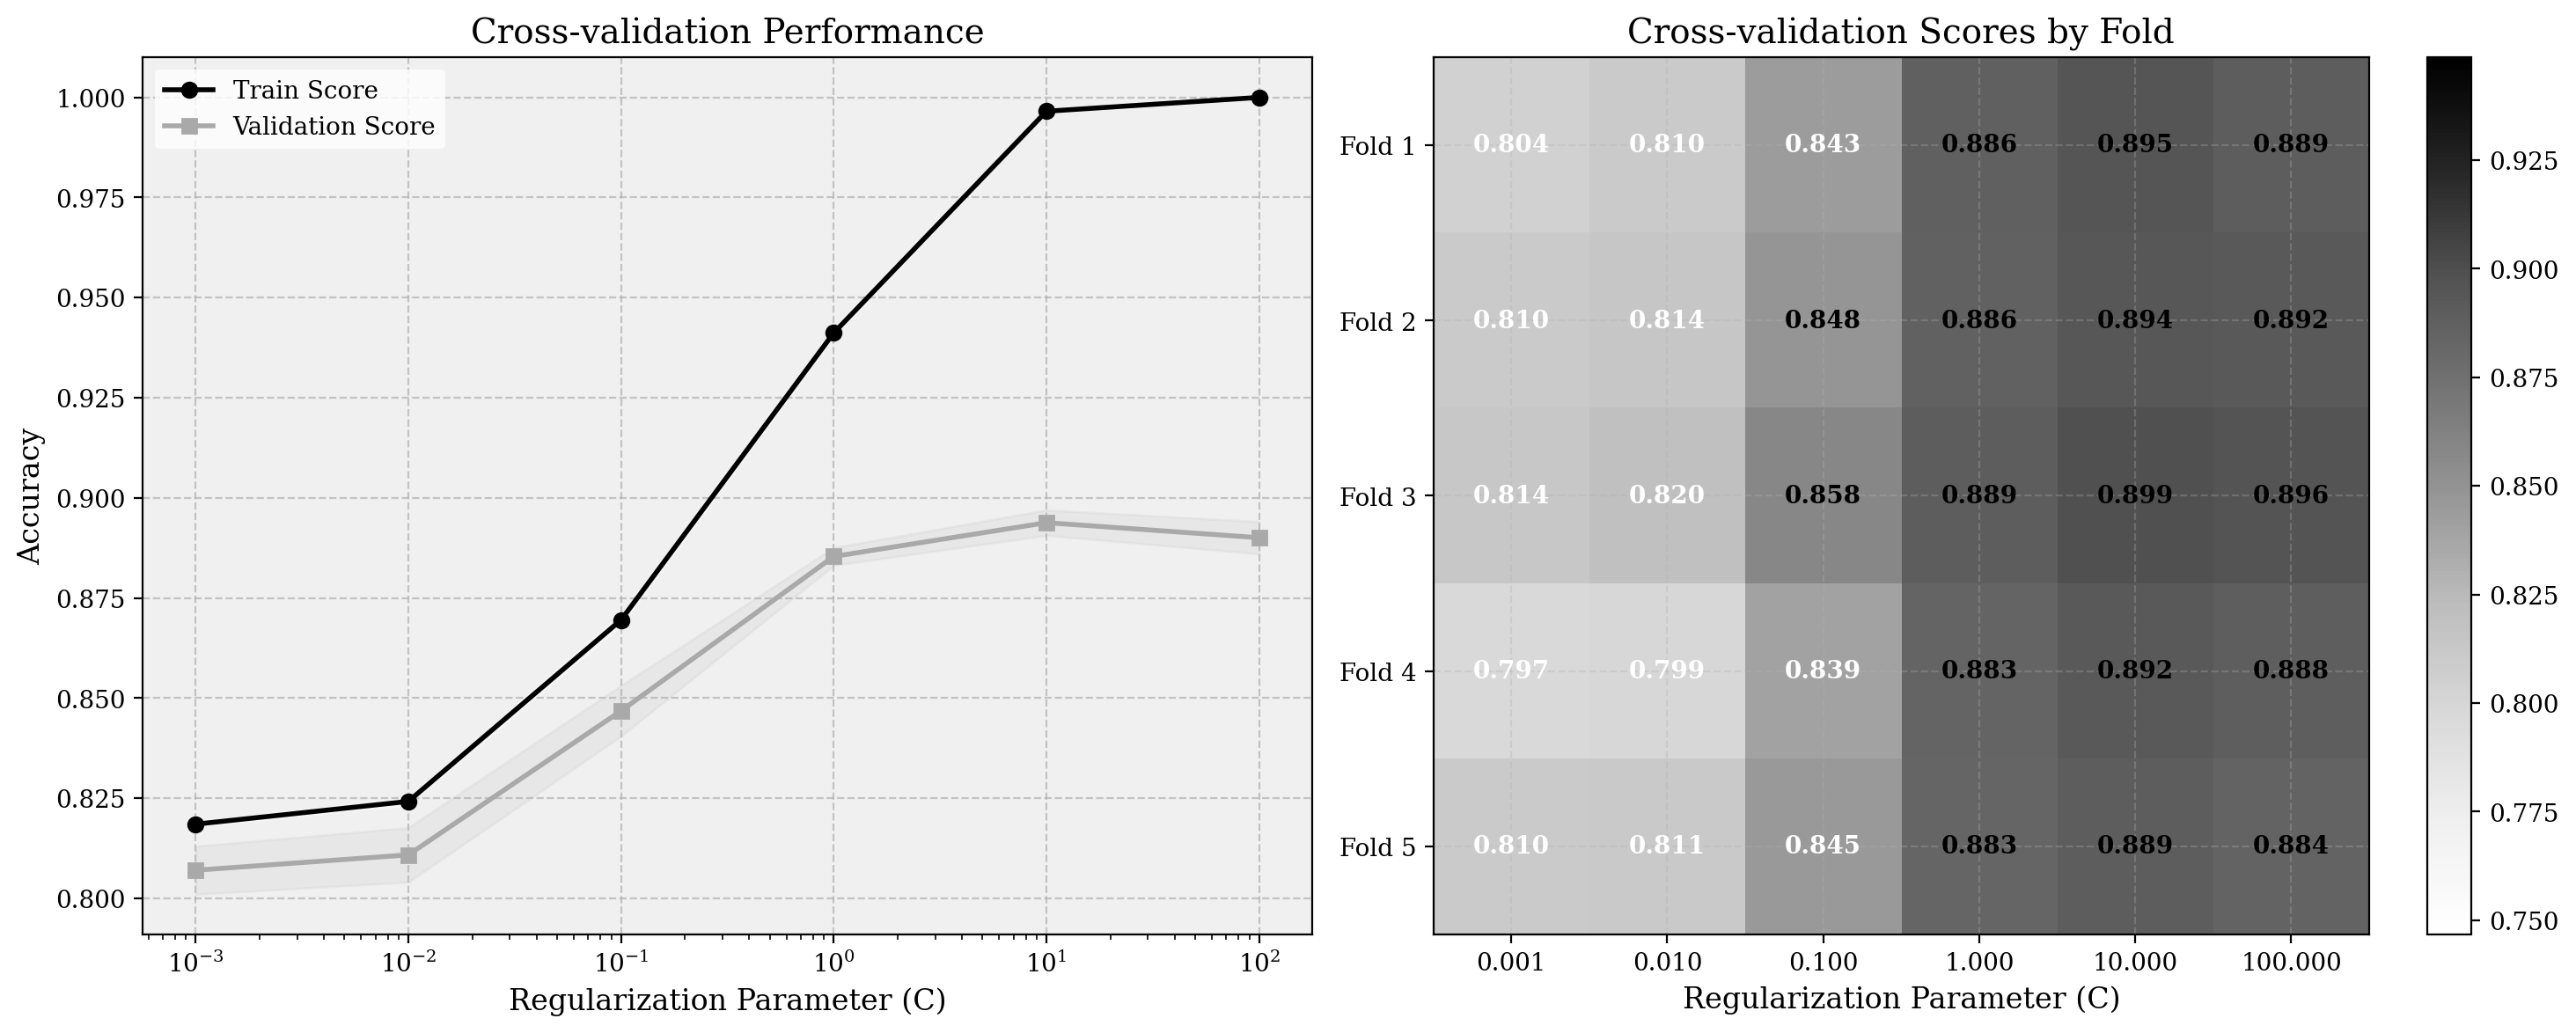

In [39]:
plot_hyperparameter_tuning(grid)

In [22]:
# find maximum value for each of the features over dataset:
max_value = X_test_tfidf.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

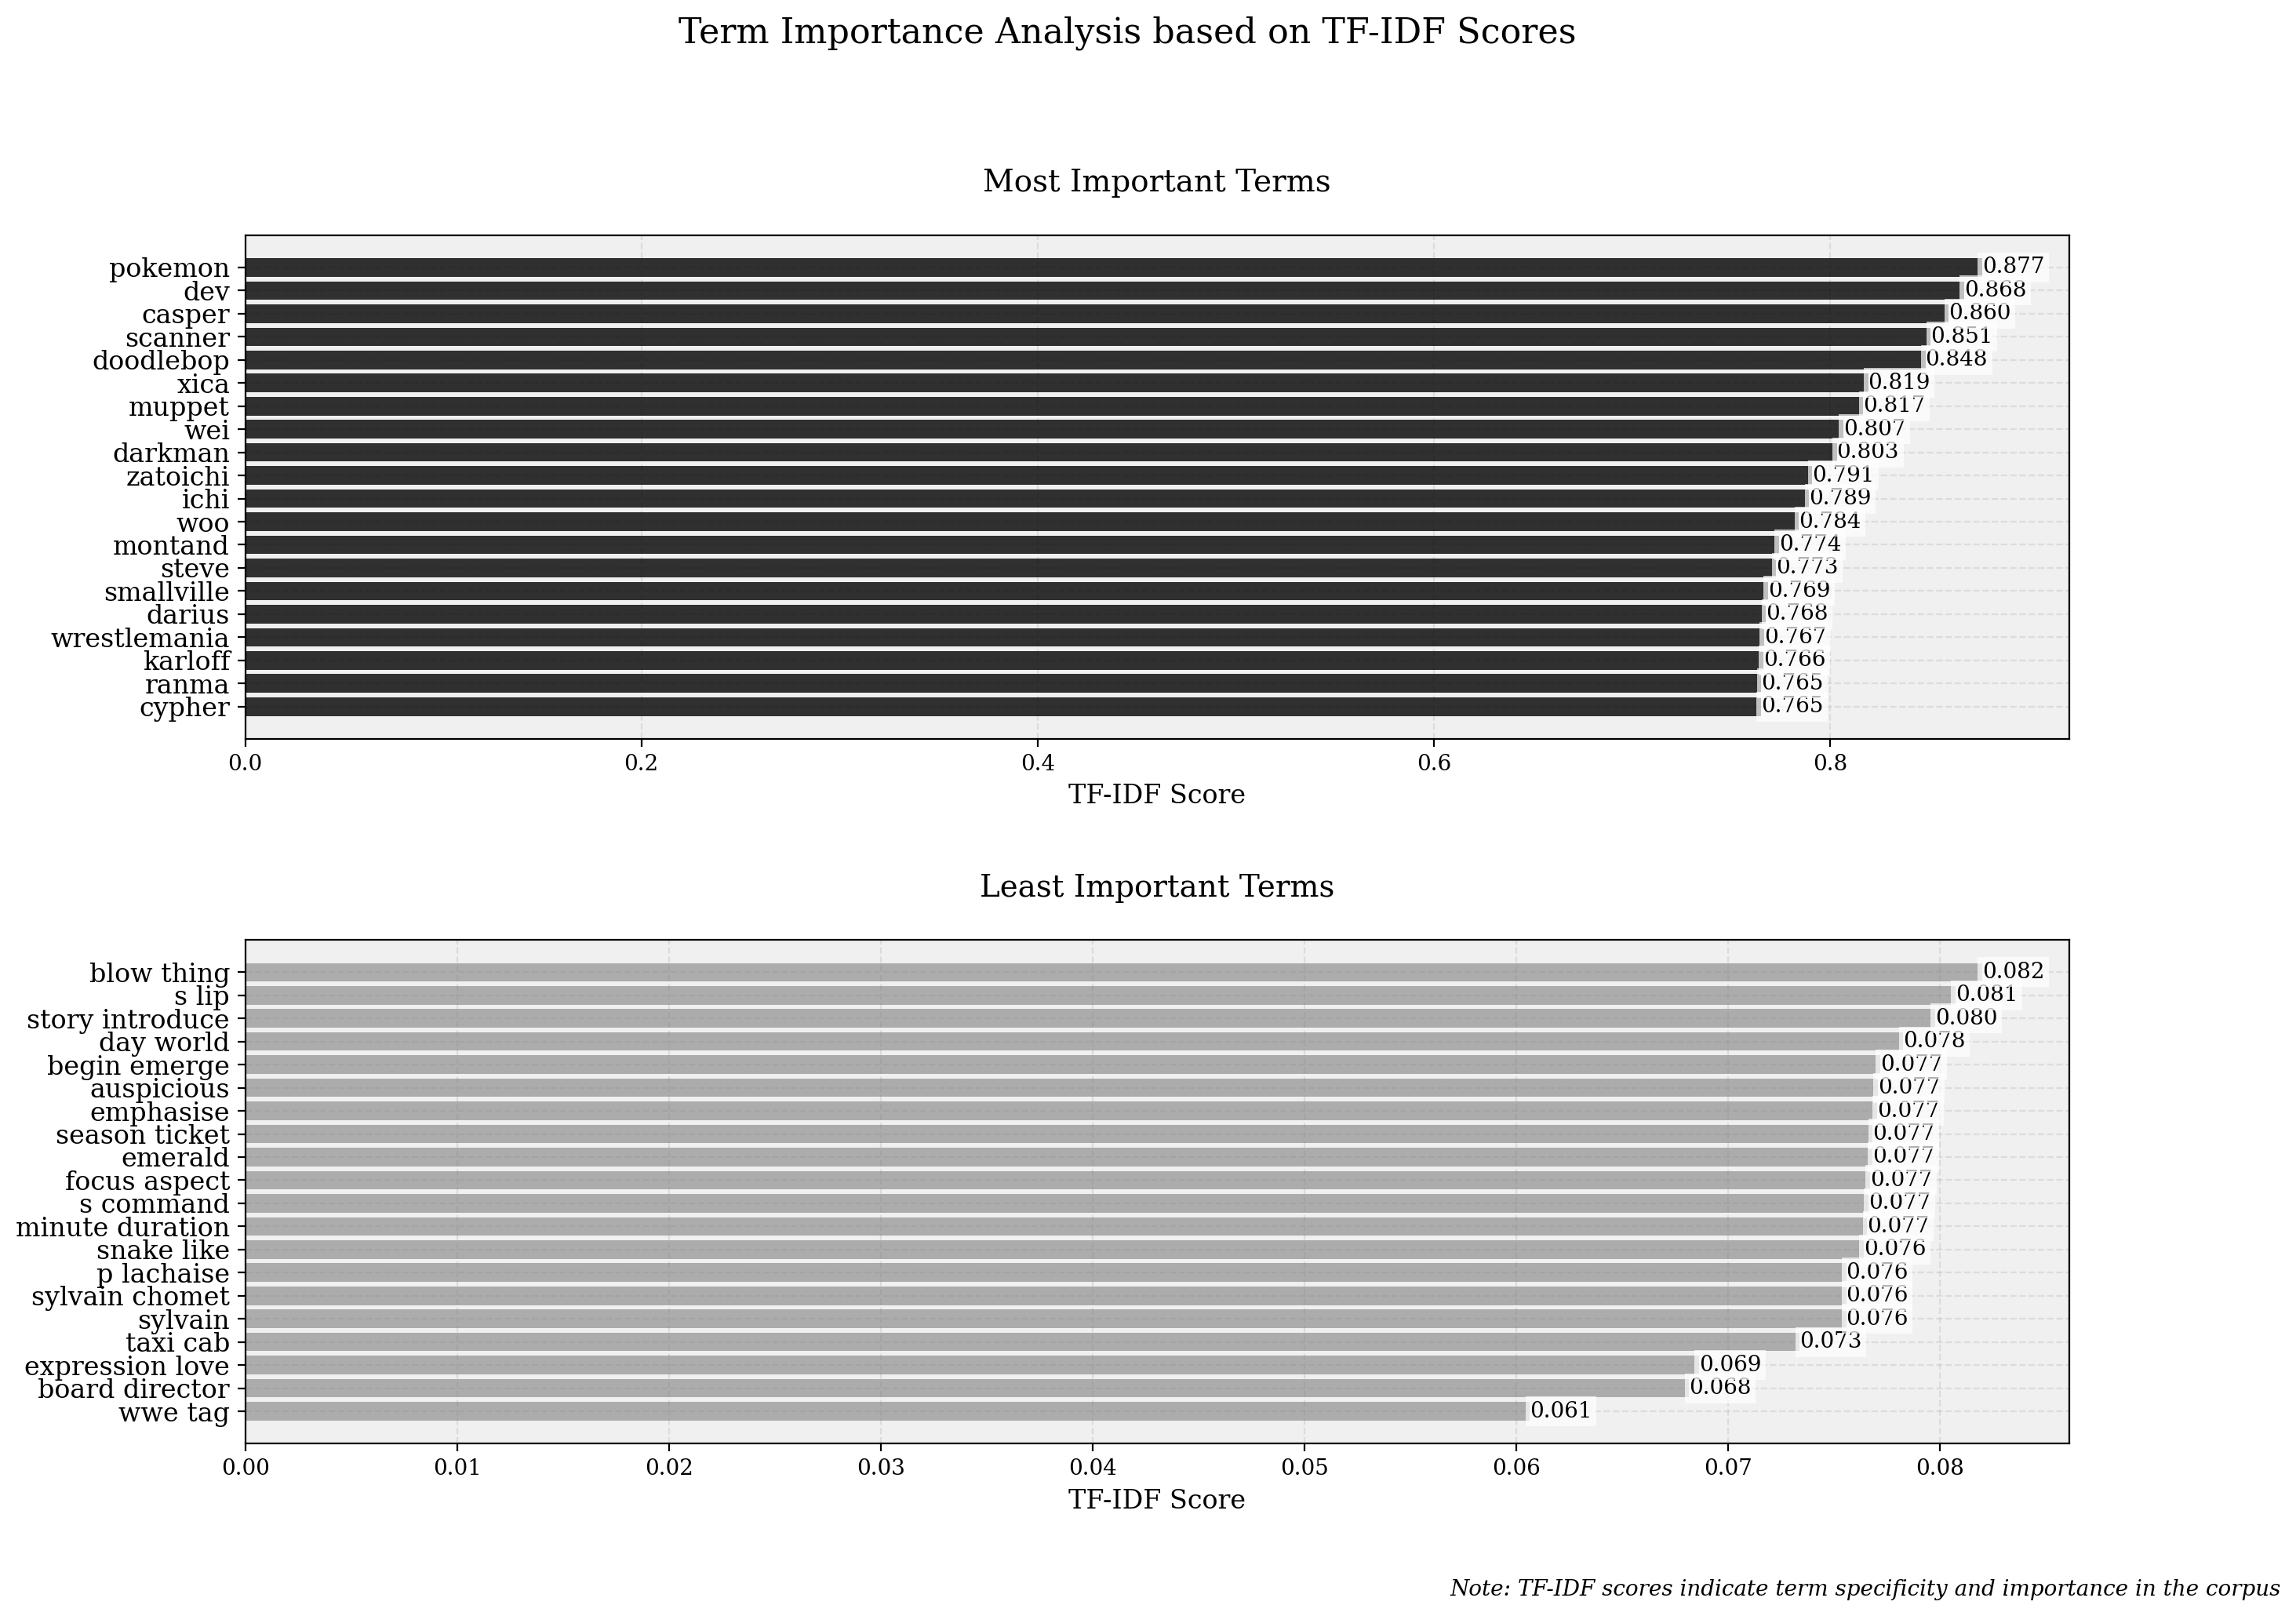

In [41]:
plot_word_importance(tfidf_spacy, X_train_tfidf, n_words=20)

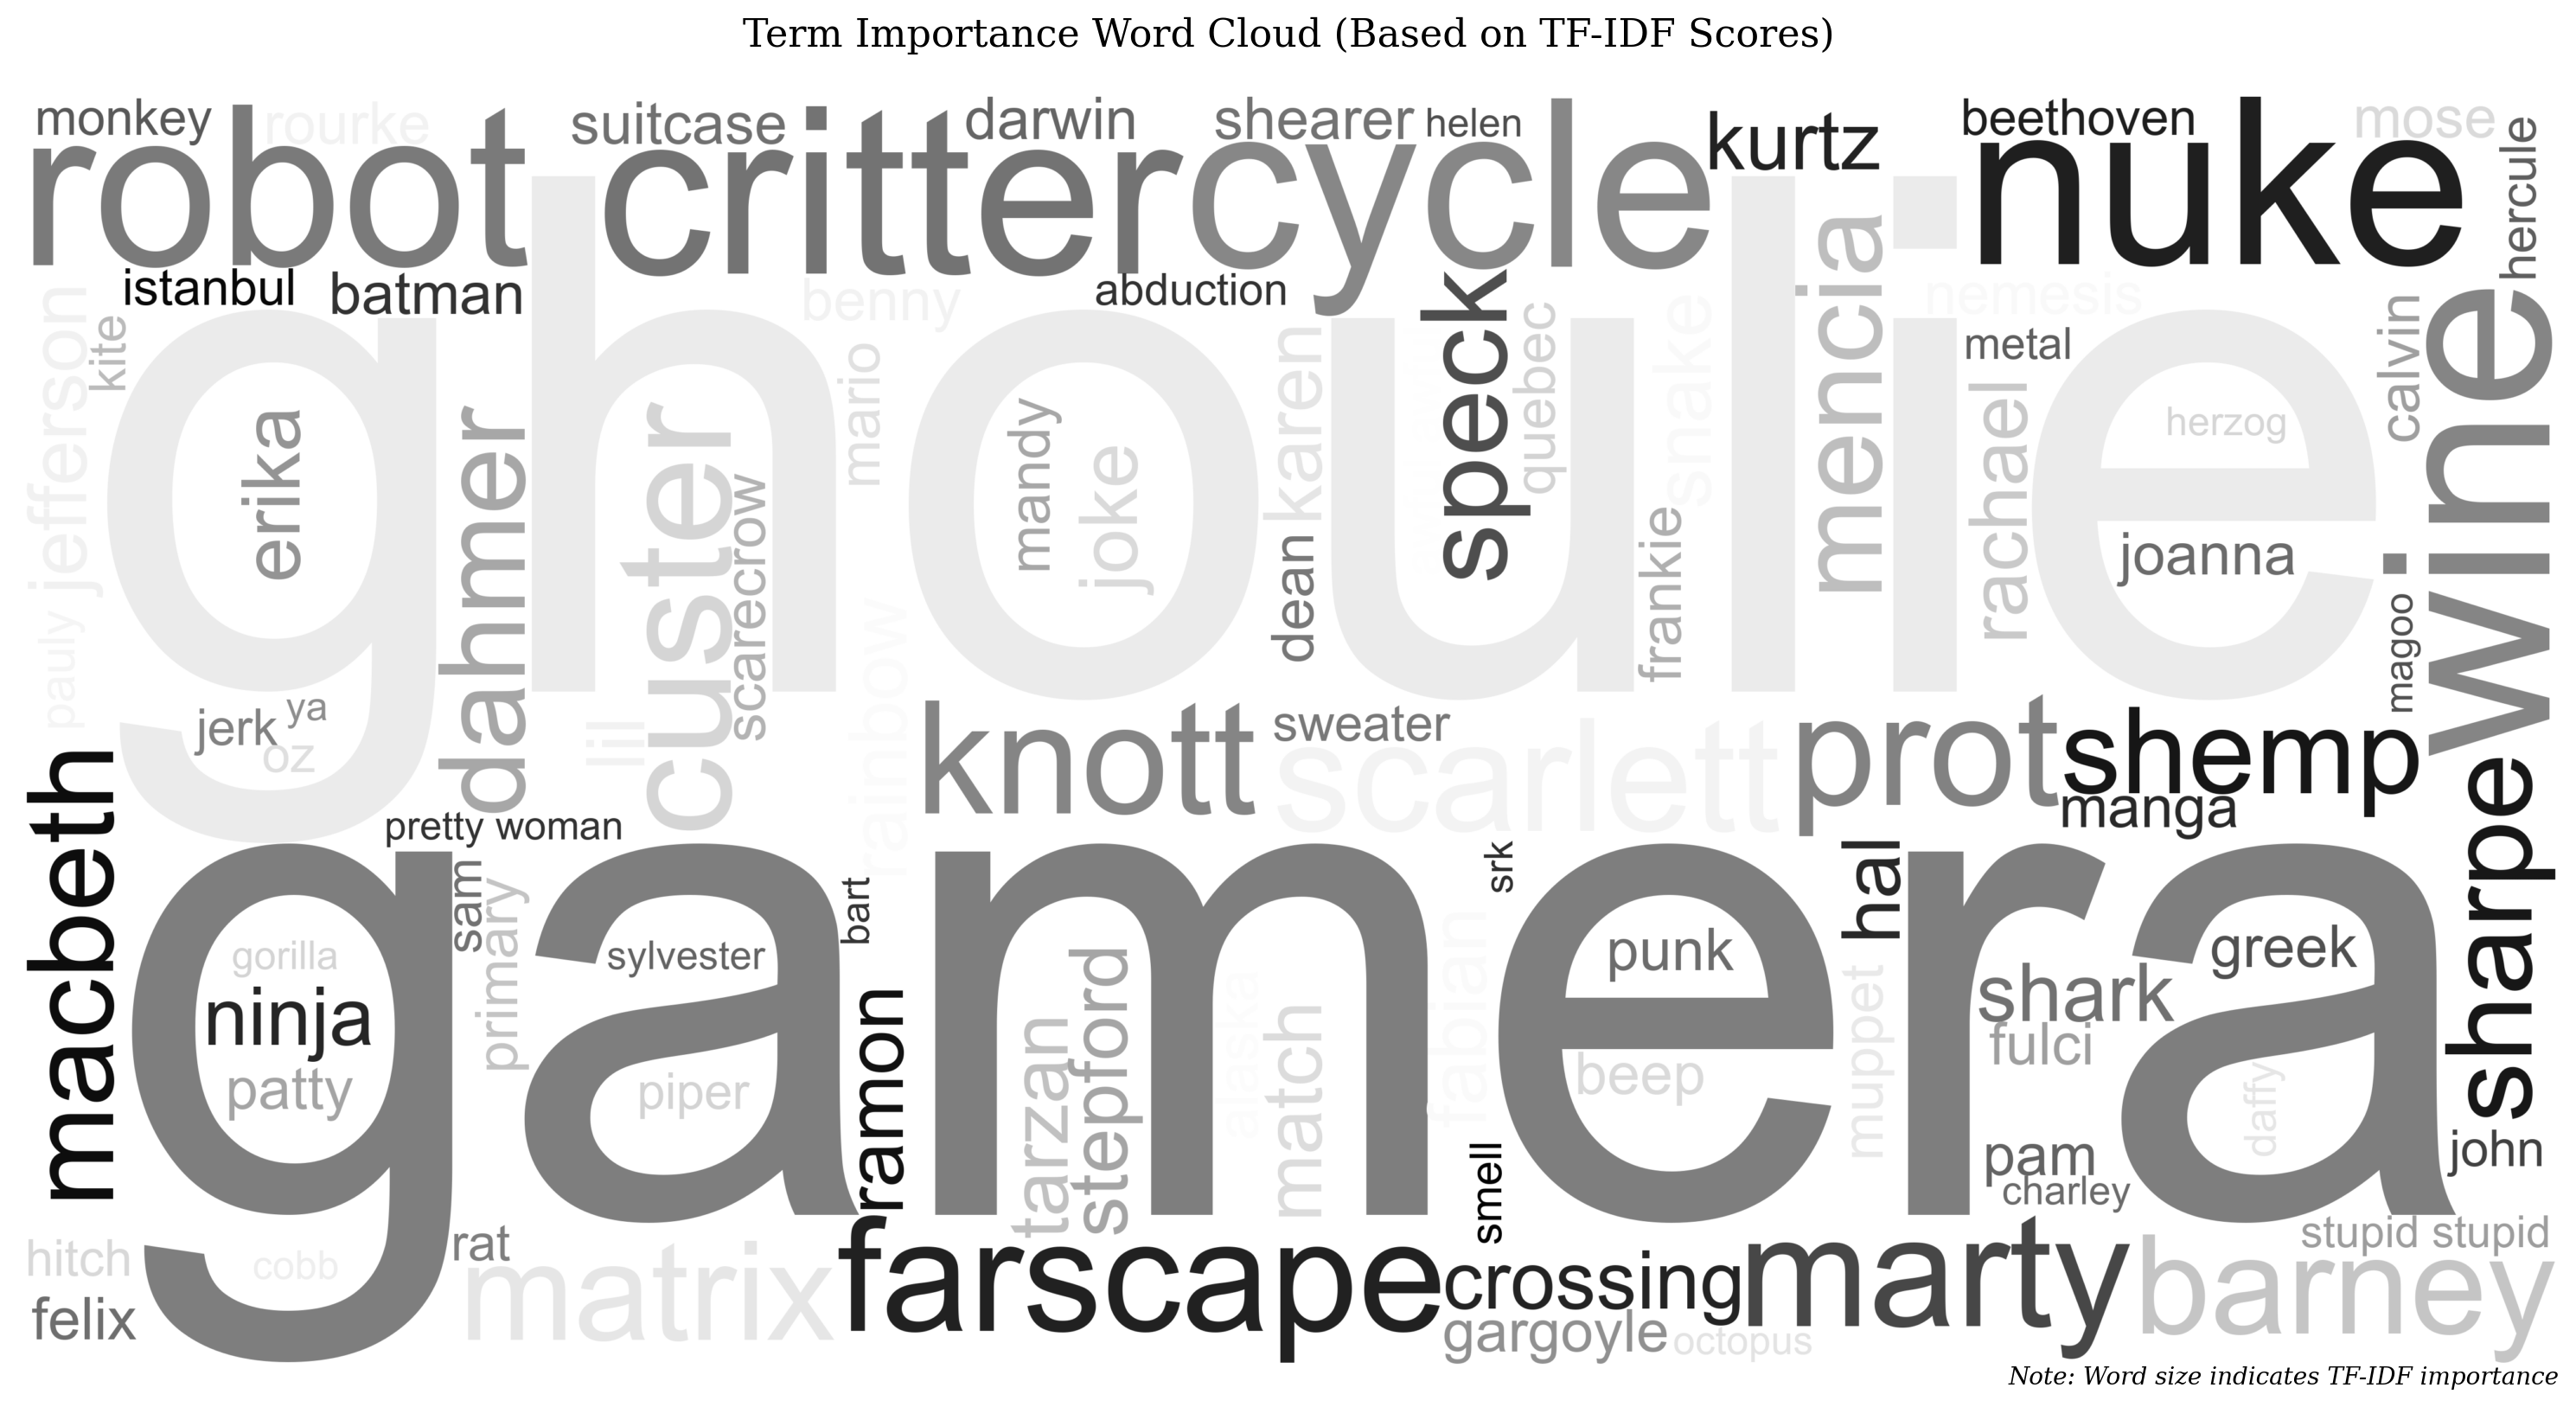

In [42]:
# 调用函数
plot_word_cloud(tfidf_spacy, max_value, n_words=100)

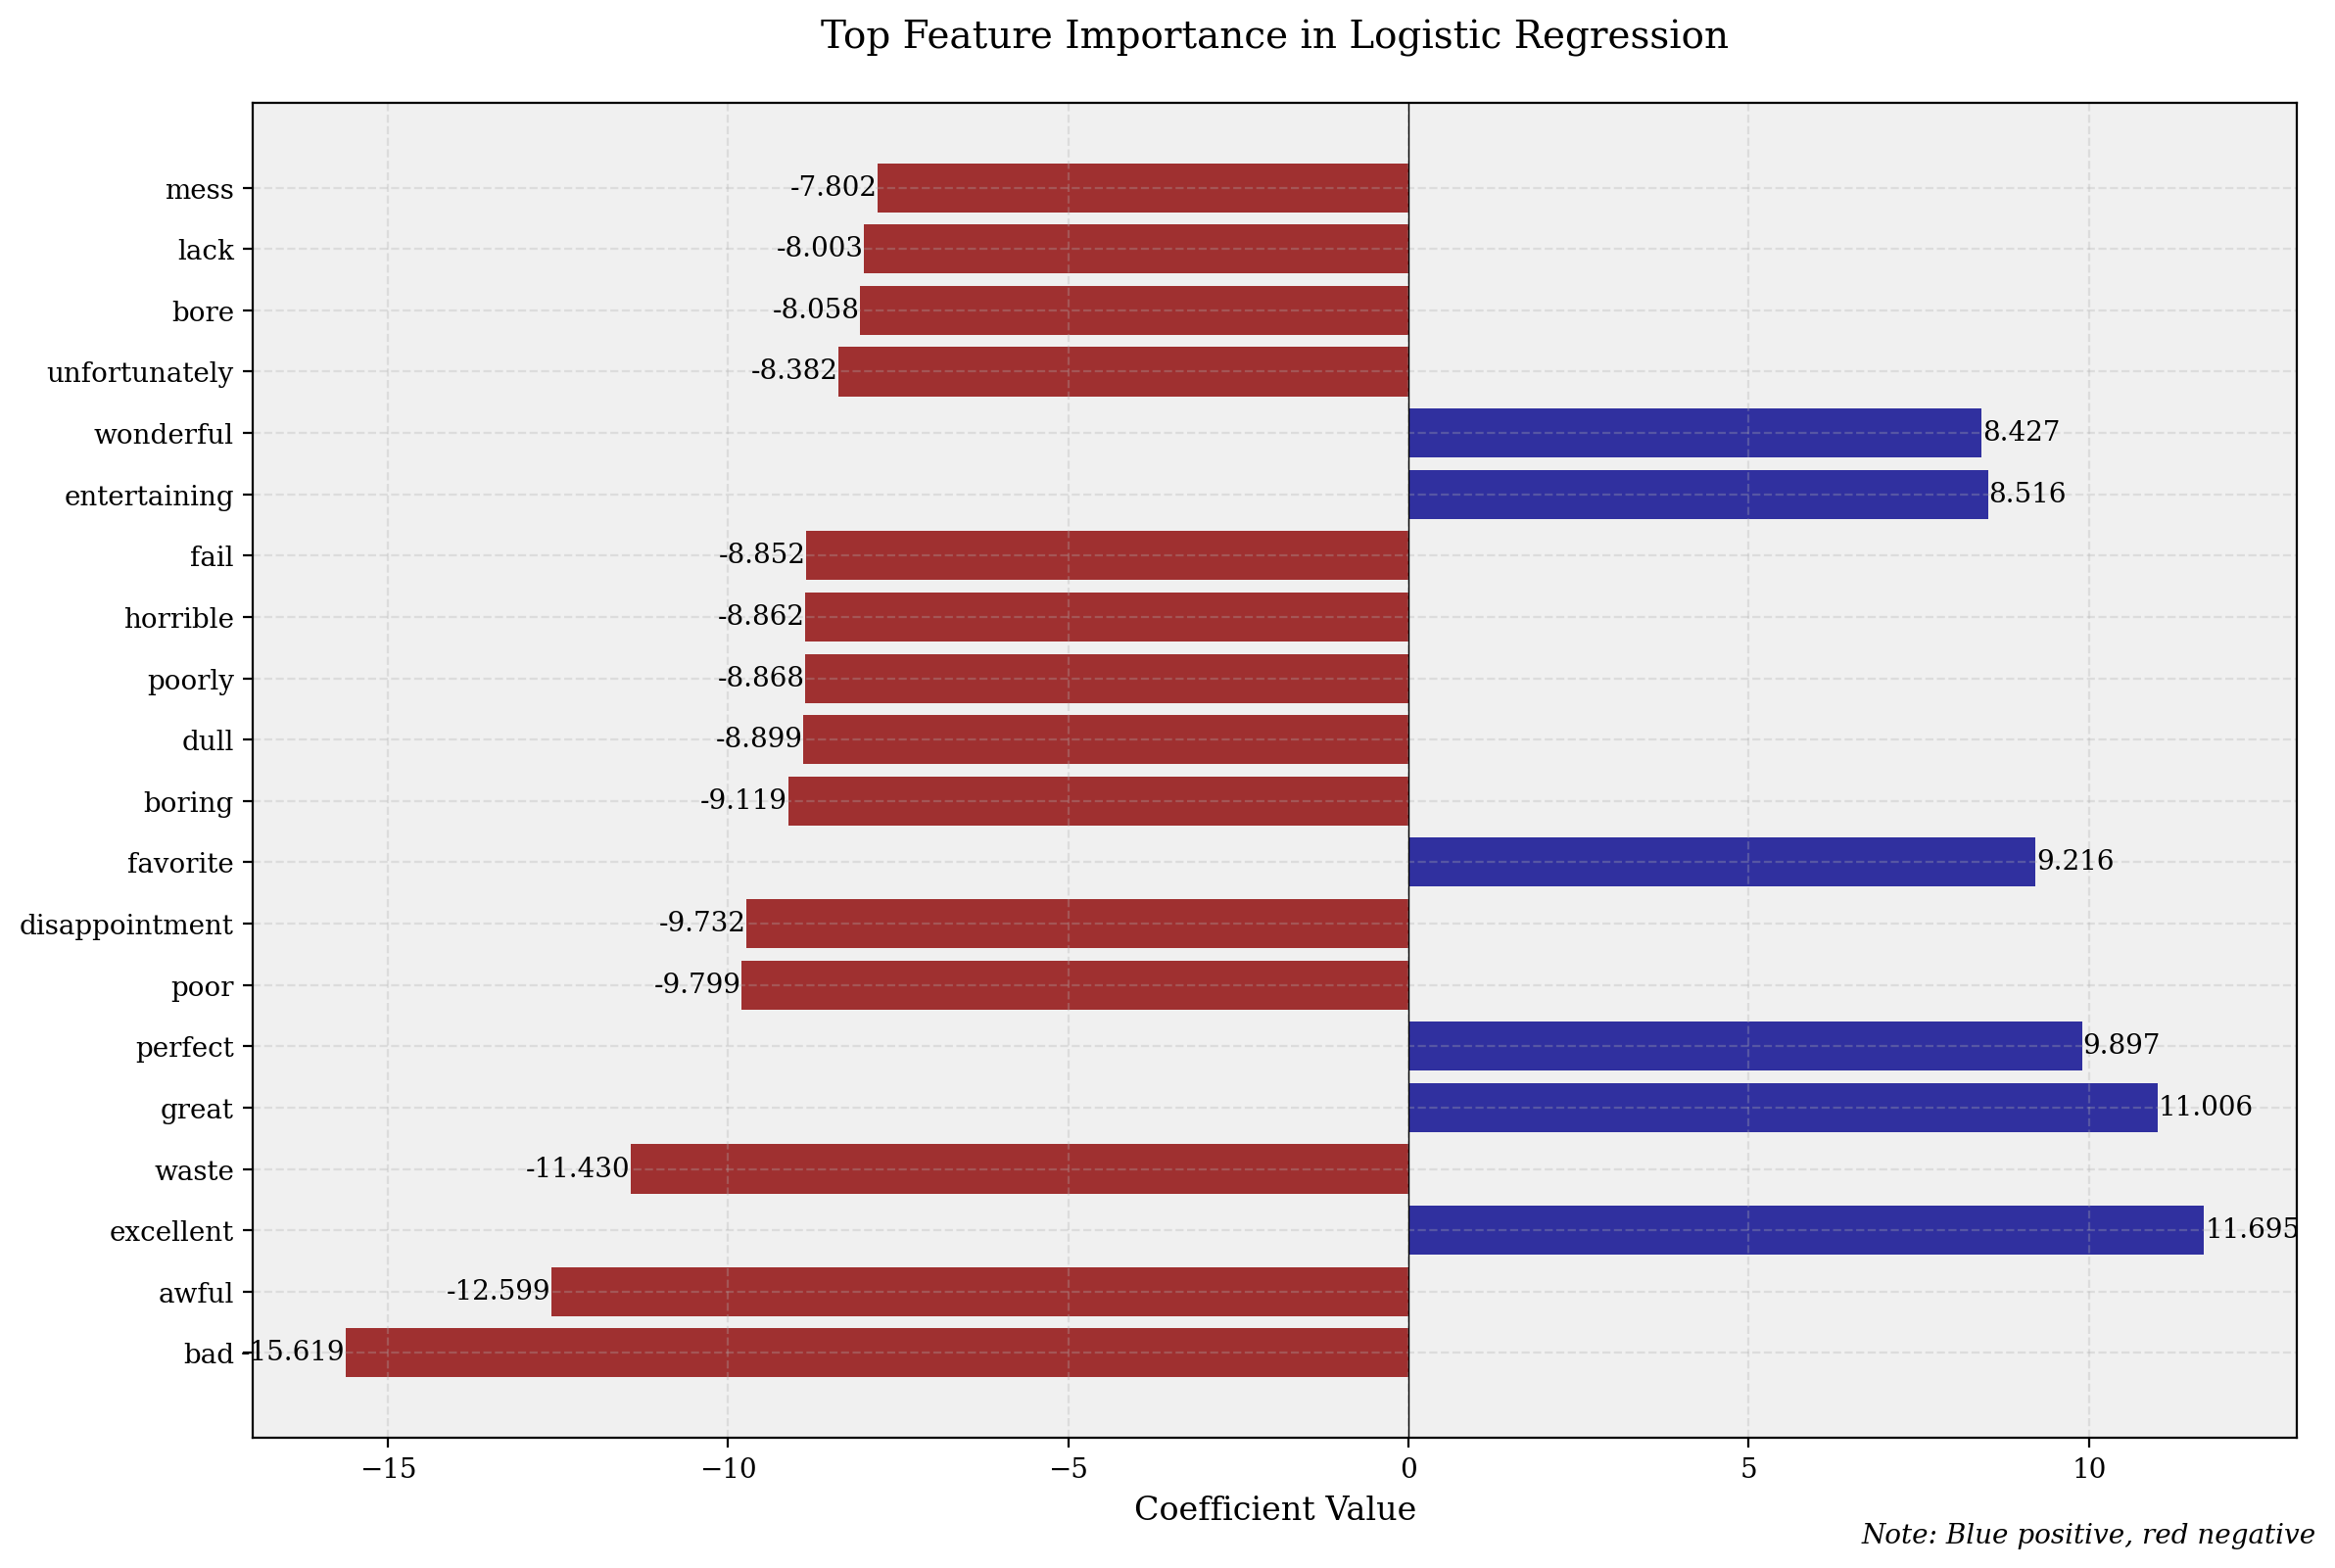

In [43]:
plot_logistic_importance(load_model, tfidf_spacy, n_features=20)

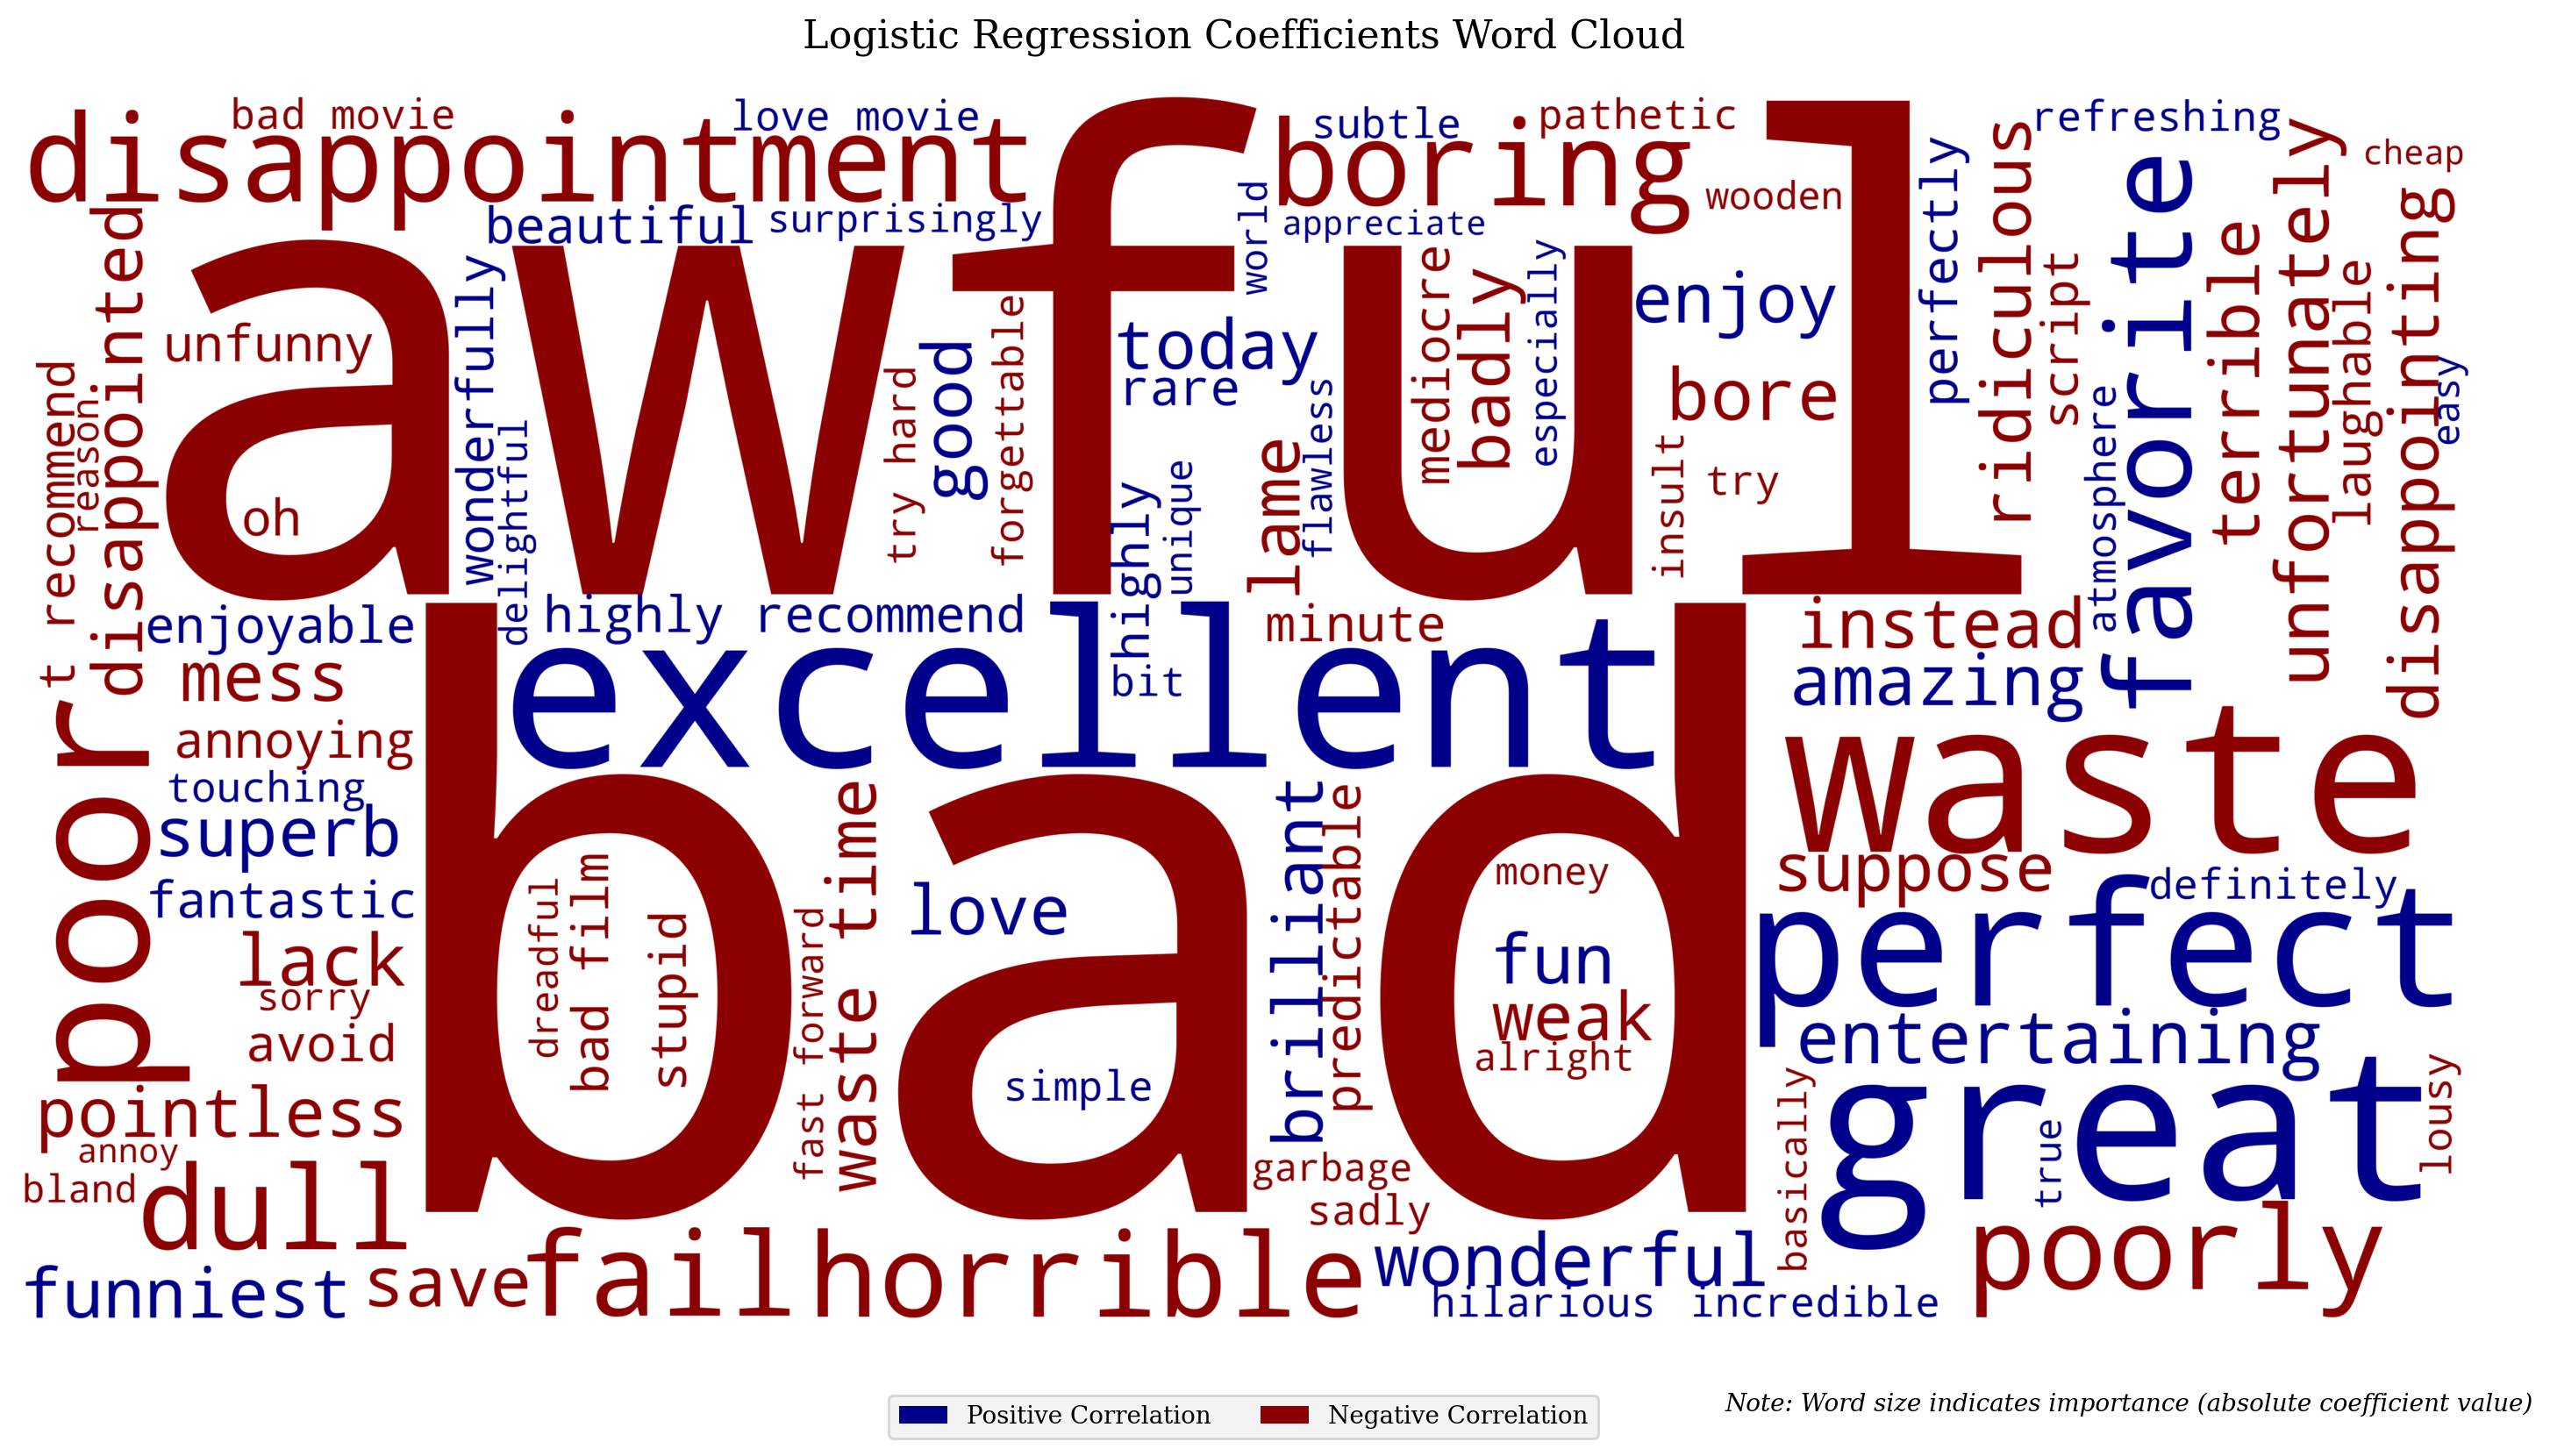

In [44]:
plot_logistic_wordcloud(load_model, tfidf_spacy, n_words=100)


1. Confusion Matrix:


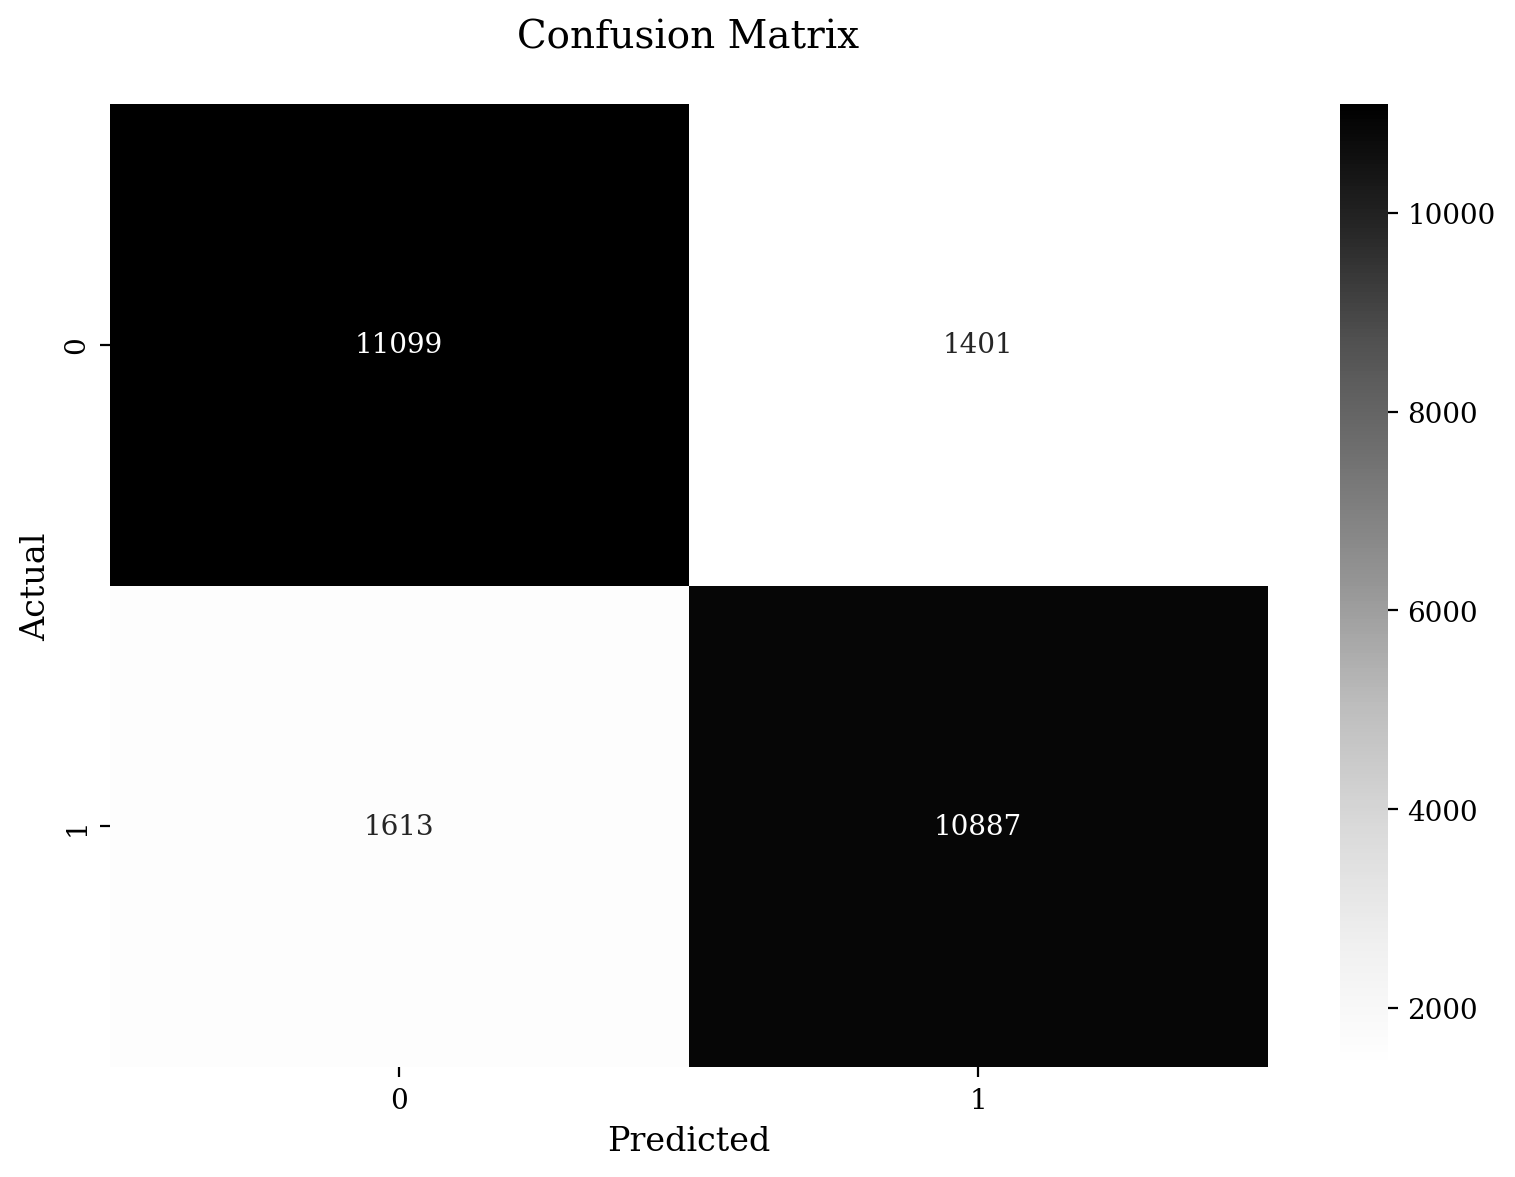


2. ROC Curve:


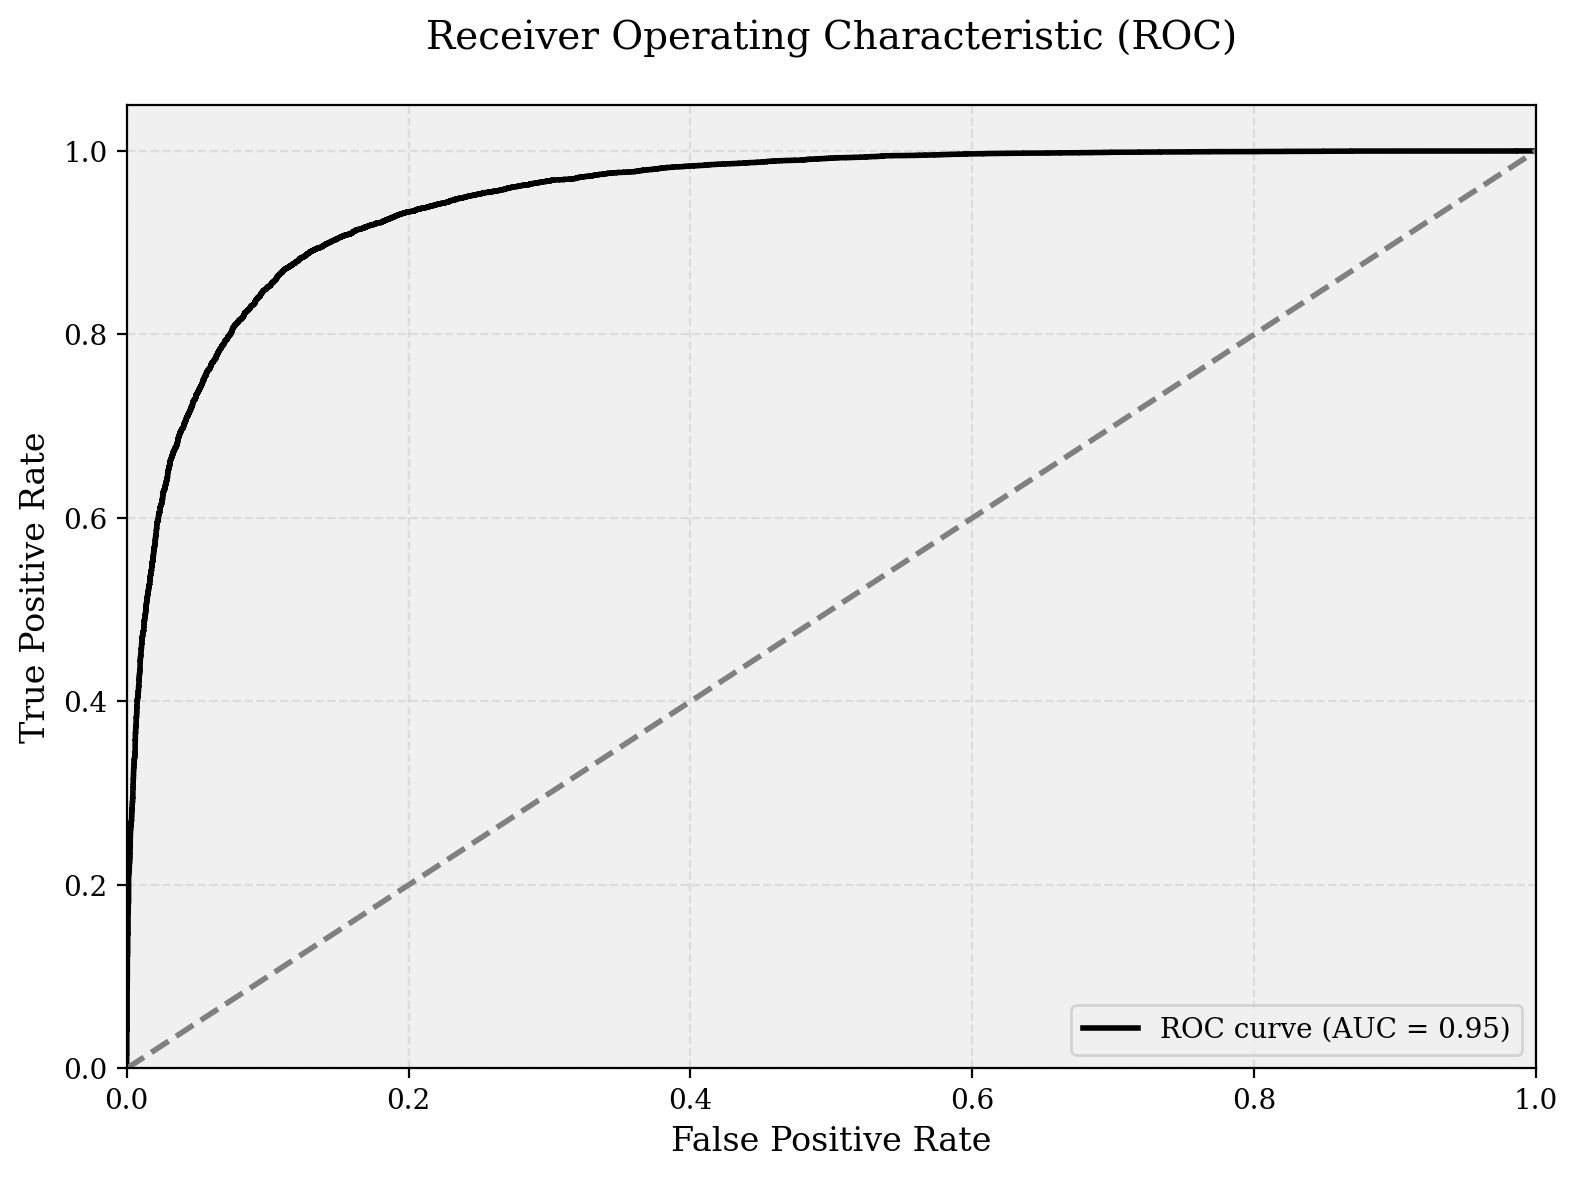


3. Precision-Recall Curve:


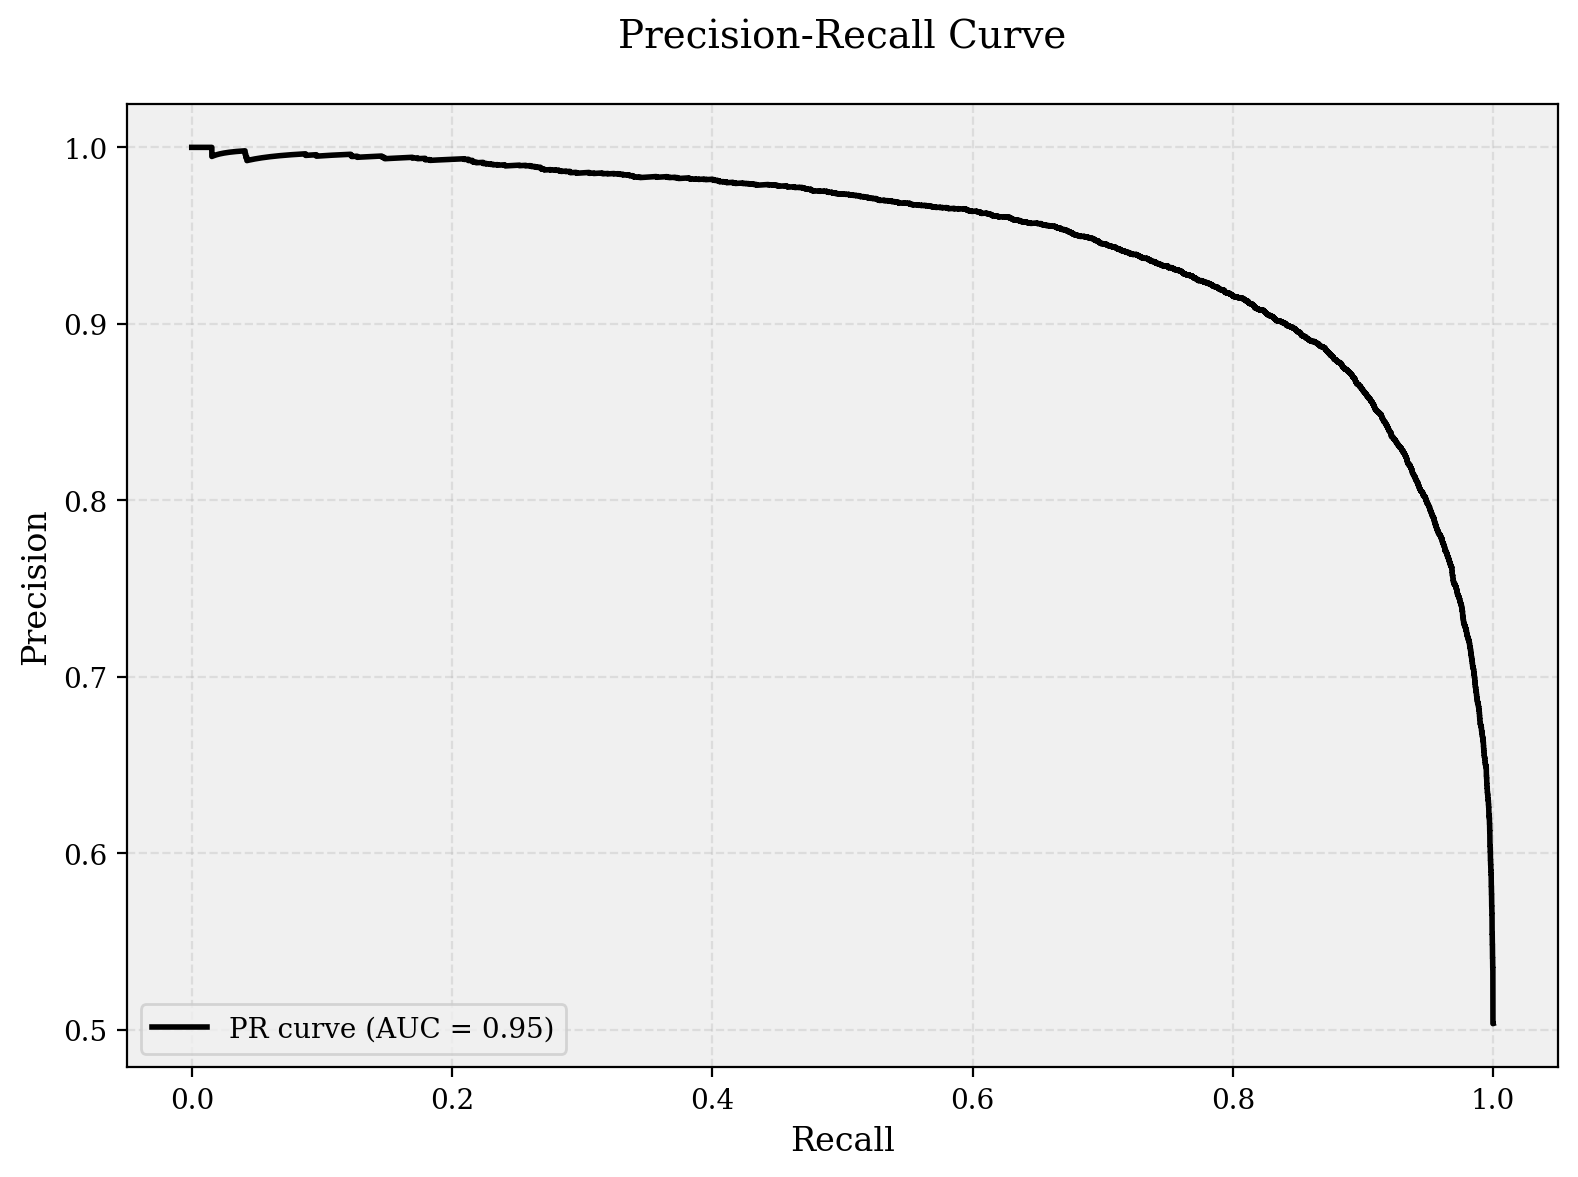


4. Performance Metrics Summary:


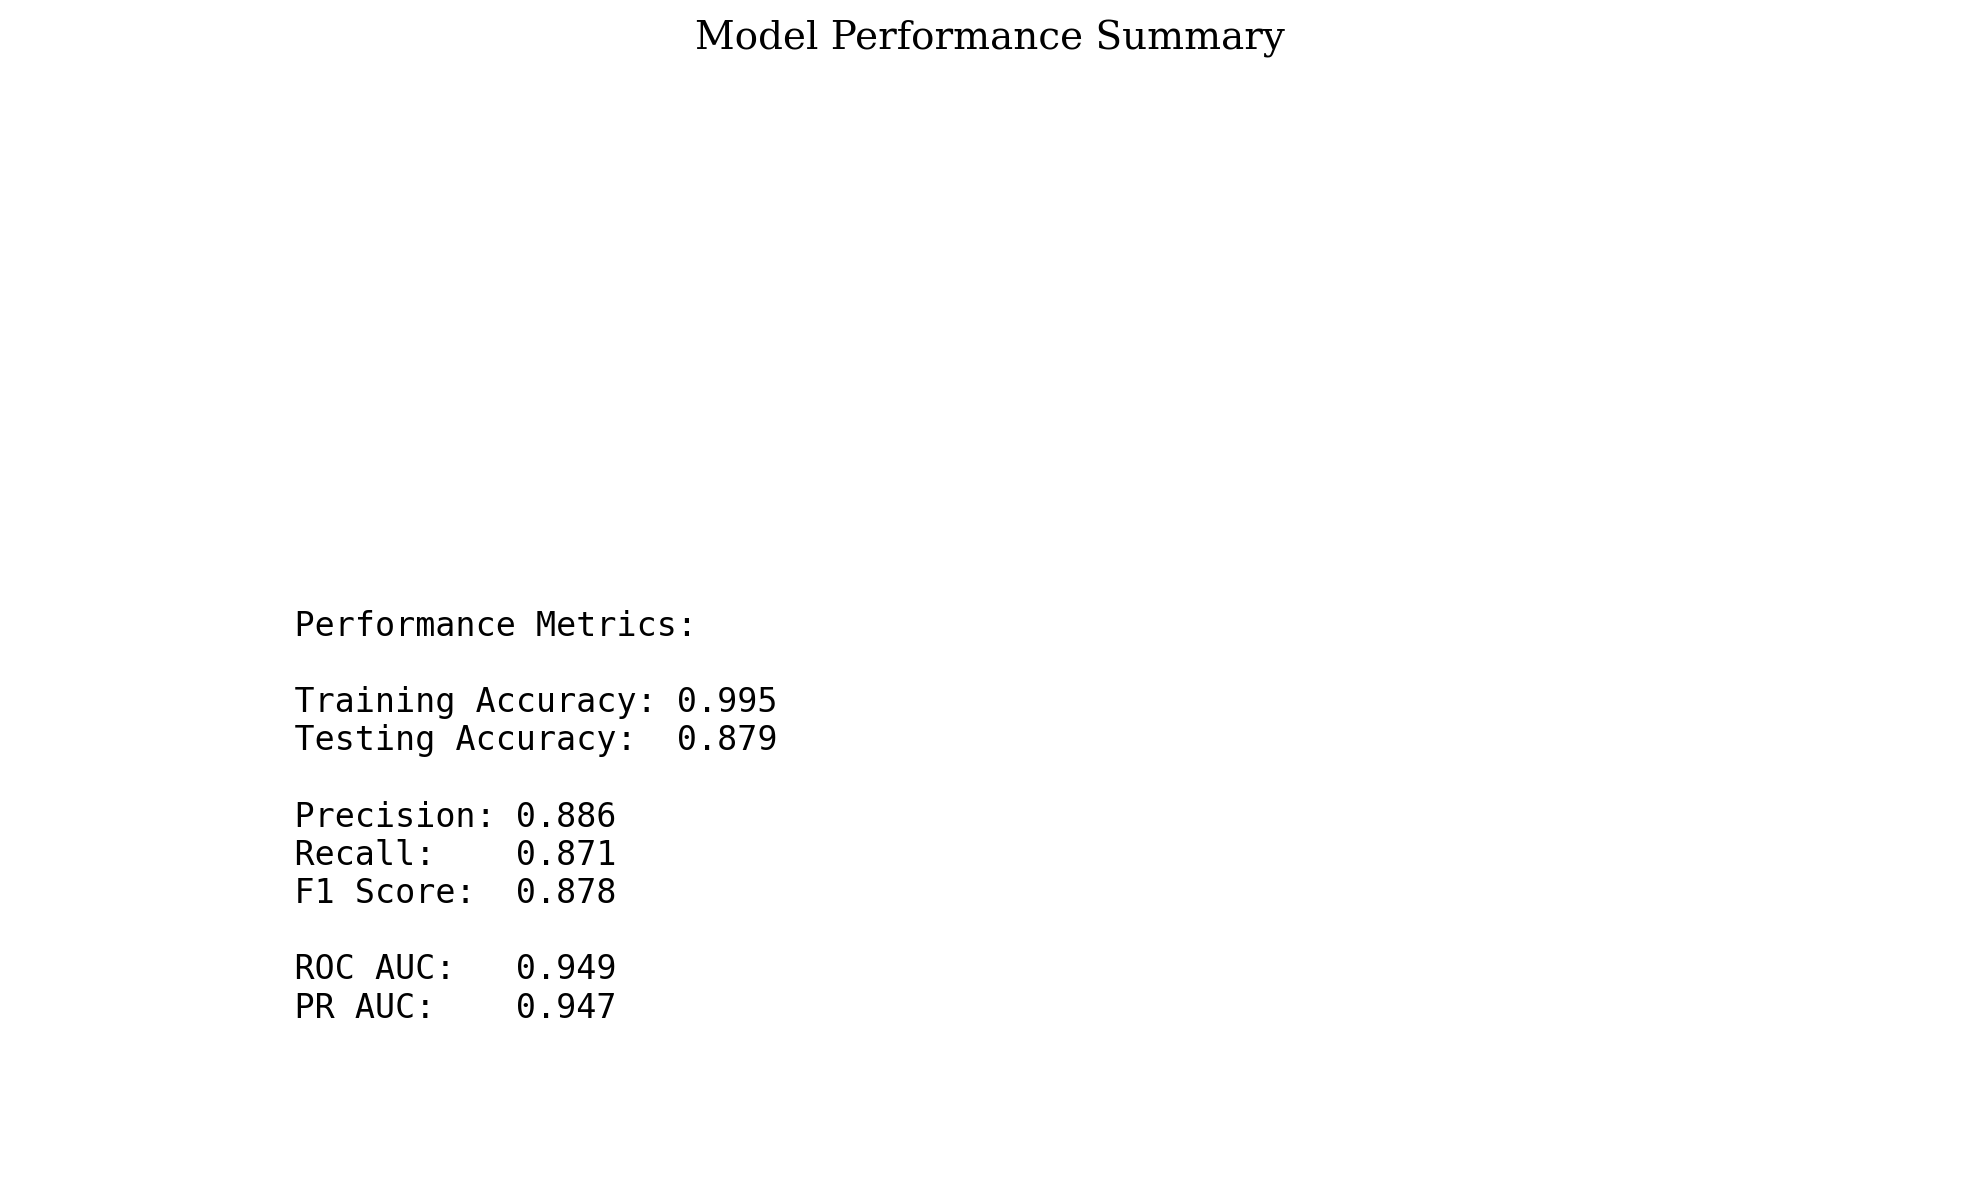


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     12500
           1       0.89      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [45]:
# 调用评估函数
metrics = evaluate_logistic_regression(load_model, X_train_tfidf, X_test_tfidf, y_train, y_test)